<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ZoeDepth/Inference_with_ZoeDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with ZoeDepth for metric depth estimation

In this notebook, we'll perform inference with [ZoeDepth](https://huggingface.co/docs/transformers/main/en/model_doc/zoedepth), a model useful for metric (also called absolute) depth estimation from a single image.

### Relative vs. absolute depth estimation

The Transformers library started by supporting various monocular depth estimation models such as [DPT](https://huggingface.co/docs/transformers/en/model_doc/dpt) and [Depth Anything v2](https://huggingface.co/docs/transformers/main/en/model_doc/depth_anything_v2). Those models are relative depth estimation models, which means that they predict the relative distance among the pixels that make up the image. They don't tell you how far off a certain pixel is from the camera. Absolute depth estimation models on the other hand can tell you that, they will provide the metric (for instance, in meters) for each pixel.

What most papers do at the time of writing is first training a model useful for relative depth estimation (often on millions of images), after which they fine-tune it for absolute (metric) depth estimation.

### Resources

* ZoeDepth [docs](https://huggingface.co/docs/transformers/main/en/model_doc/zoedepth)
* ZoeDepth [checkpoints](https://huggingface.co/models?other=zoedepth)
* [Paper](https://arxiv.org/abs/2302.12288)

## Set-up environment

Let's start by installing 🤗 Transformers. We install from source here since the model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 257870, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 257870 (delta 186), reused 219 (delta 107), pack-reused 257507
Receiving objects: 100% (257870/257870), 242.62 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (186490/186490), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model and image processor

Next we load a ZoeDepth model from the 🤗 hub. Note that the authors have released several checkpoints (one trained on NYU, one trained on KITI, and one trained on both).

In [2]:
from transformers import ZoeDepthImageProcessor, ZoeDepthForDepthEstimation

image_processor = ZoeDepthImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti")
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti")

preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

## Load image

Next, let's load an image on which we'd like to predict depth.

examples/person_1.jpeg:   0%|          | 0.00/341k [00:00<?, ?B/s]

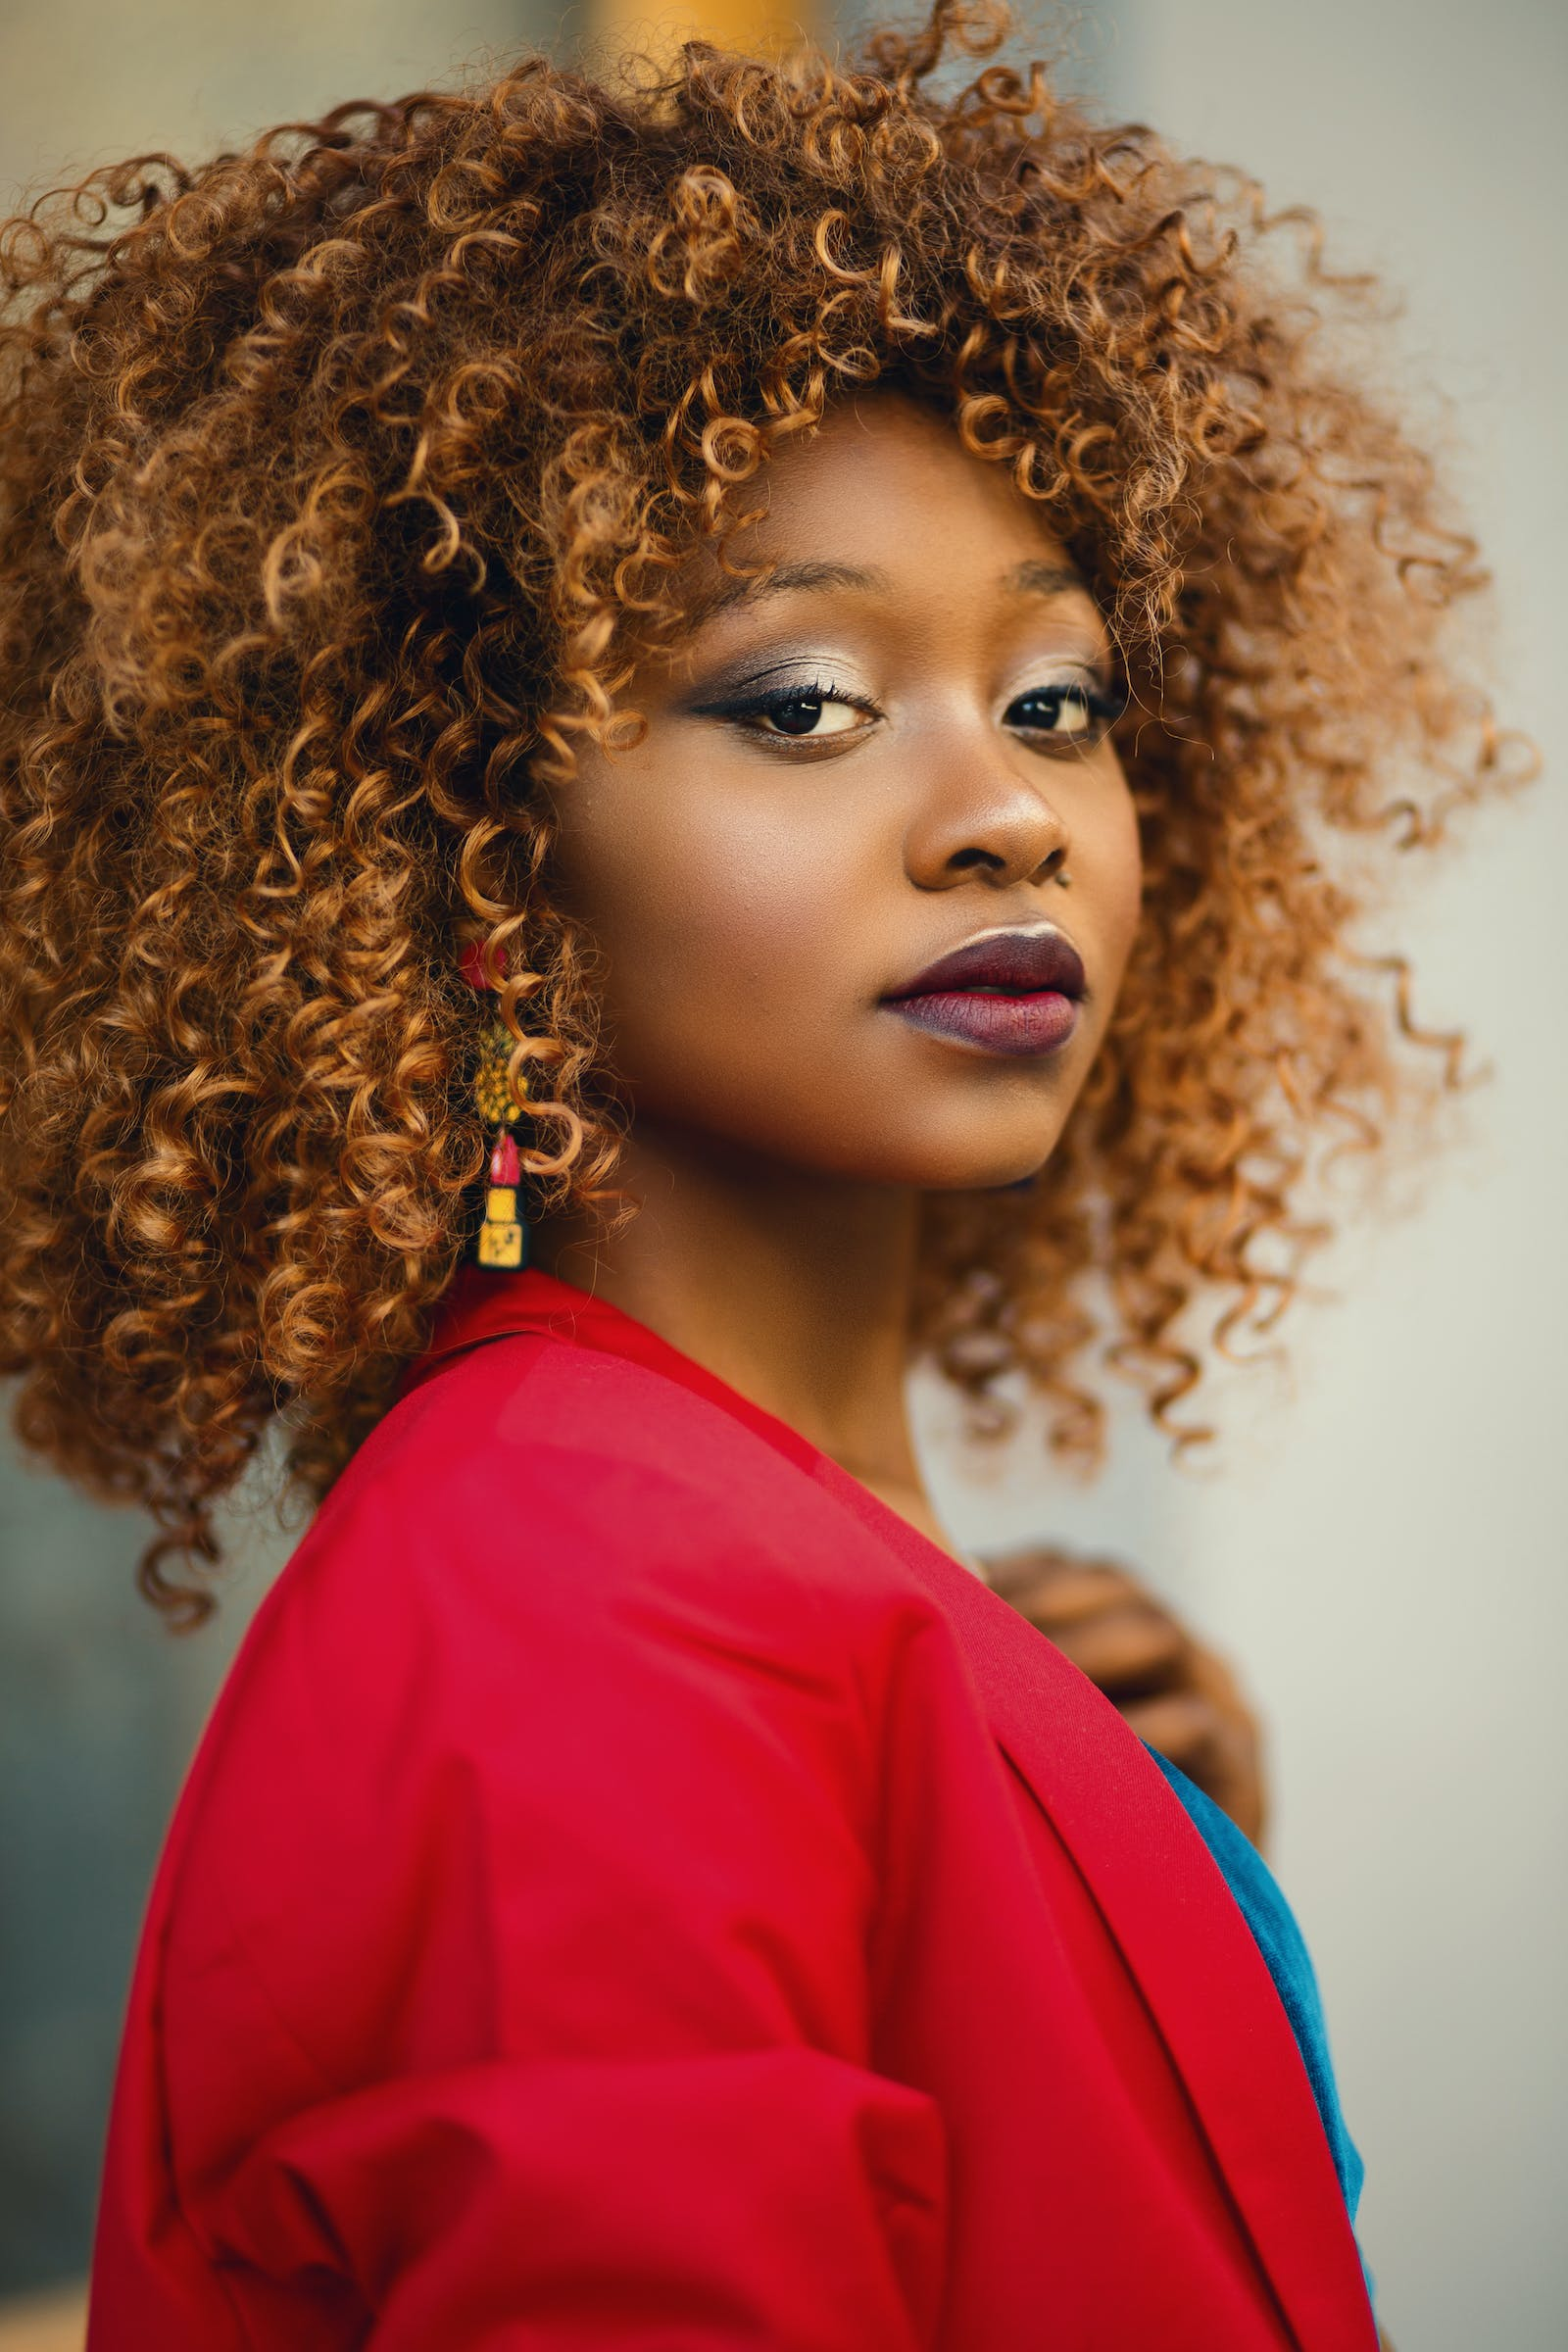

In [3]:
from PIL import Image
import requests
from huggingface_hub import hf_hub_download

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

filepath = hf_hub_download(repo_id="shariqfarooq/ZoeDepth", filename="examples/person_1.jpeg", repo_type="space")
image = Image.open(filepath).convert("RGB")
image

In [4]:
image.size

(1600, 2400)

## Forward pass

Next we prepare the image for the model and perform a forward pass.

In [5]:
pixel_values = image_processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 768, 512])


In [6]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

## Postprocess

Next we postprocess the predicted depth as done in the [original implementation](https://github.com/isl-org/ZoeDepth/blob/edb6daf45458569e24f50250ef1ed08c015f17a7/zoedepth/models/depth_model.py#L88-L96). We interpolate the predicted depth to the size of the pixel values and crop to the original input size.

In [7]:
import numpy as np
import torch.nn.functional as F

# postprocessing
predicted_depth = outputs.predicted_depth.unsqueeze(dim=1)

height, width = pixel_values.shape[2:]

# the original implementation also pads the final output
pad_input = True
height_padding_factor = width_padding_factor = 3
pad_h = int(np.sqrt(height/2) * height_padding_factor)
pad_w = int(np.sqrt(width/2) * width_padding_factor)

if predicted_depth.shape[-2:] != pixel_values.shape[-2:]:
    predicted_depth = F.interpolate(predicted_depth, size=(height, width), mode='bicubic', align_corners=False)
if pad_input:
    # crop to the original size, handling the case where pad_h and pad_w is 0
    if pad_h > 0:
        predicted_depth = predicted_depth[:, :, pad_h:-pad_h,:]
    if pad_w > 0:
        predicted_depth = predicted_depth[:, :, :, pad_w:-pad_w]

In [8]:
print(predicted_depth.shape)

torch.Size([1, 1, 652, 416])


## Visualize result

In [9]:
import matplotlib

def colorize(value, vmin=None, vmax=None, cmap='gray_r', invalid_val=-99, invalid_mask=None, background_color=(128, 128, 128, 255), gamma_corrected=False, value_transform=None):
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarry): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask],2) if vmin is None else vmin
    vmax = np.percentile(value[mask],85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img

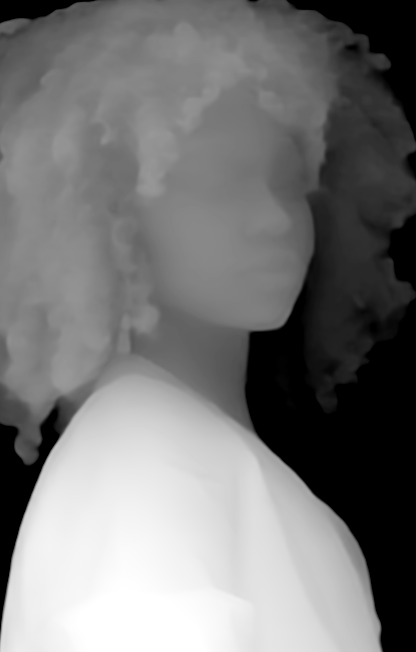

In [10]:
result = colorize(predicted_depth.squeeze().numpy())
Image.fromarray(result)

## Pipeline API

Alternatively, one can use the pipeline which performs what we did above for us:

In [11]:
from transformers import pipeline
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pipe = pipeline(task="depth-estimation", model="Intel/zoedepth-nyu-kitti")
result = pipe(image)
depth = result["depth"]

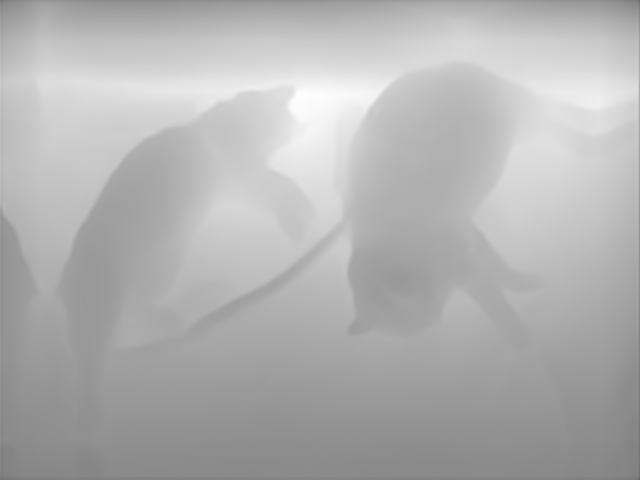

In [12]:
depth